In [37]:
# conda install netcdf4 h5netcdf
# Libraries for working with multidimensional arrays
import cdsapi

import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import datetime as dt
from shapely.geometry import Point, MultiPoint
from shapely.ops import nearest_points

# Libraries for plotting and visualising data
import matplotlib.path as mpath
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature

# Disable warnings for data download via API
import urllib3 
urllib3.disable_warnings()

## Data from Copernicus

+ Access [here](https://cds.climate.copernicus.eu/datasets/insitu-gridded-observations-europe?tab=download)

In [ ]:
# DEFINE YOU API AND URL
URL = 'https://cds.climate.copernicus.eu/api/'
KEY = %yourapikey

In [4]:
# dataset = "insitu-gridded-observations-europe"
# request = {
#     "product_type": "ensemble_mean",
#     "variable": [
#         "mean_temperature",
#         "minimum_temperature",
#         "maximum_temperature",
#         "relative_humidity"
#     ],
#     "grid_resolution": "0_1deg",
#     "period": "2011_2024",
#     "version": ["30_0e"]
# }
# client = cdsapi.Client(url= URL, key=KEY)
# client.retrieve(dataset, request).download()

In [5]:
t_mean = 'DATA Copernicus/insitu-gridded-observations-europe_2011_2024/tg_ens_mean_0.1deg_reg_2011-2024_v30.0e.nc'
xr_tmean = xr.open_dataset(t_mean) # Mean temperature xarray
xr_tmean = xr_tmean.sel(latitude = slice(36.5, 42.5), longitude = slice(-10, -6))
t_max = 'DATA Copernicus/insitu-gridded-observations-europe_2011_2024/tx_ens_mean_0.1deg_reg_2011-2024_v30.0e.nc'
xr_tmax = xr.open_dataset(t_max) # Maximum temperature xarray
xr_tmax = xr_tmax.sel(latitude = slice(36.5, 42.5), longitude = slice(-10, -6))
t_min = 'DATA Copernicus/insitu-gridded-observations-europe_2011_2024/tn_ens_mean_0.1deg_reg_2011-2024_v30.0e.nc'
xr_tmin = xr.open_dataset(t_min) # Minimum temperature xarray
xr_tmin = xr_tmin.sel(latitude = slice(36.5, 42.5), longitude = slice(-10, -6))
hu = 'DATA Copernicus/insitu-gridded-observations-europe_2011_2024/hu_ens_mean_0.1deg_reg_2011-2024_v30.0e.nc'
xr_hu = xr.open_dataset(hu) # Relative Humidity temperature xarray
xr_hu = xr_hu.sel(latitude = slice(36.5, 42.5), longitude = slice(-10, -6))

In [6]:
# Correction
xr_tmean['latitude'] = xr_tmax['latitude']

In [7]:
aux = pd.DataFrame({'time':xr_hu['time'].values, 'idx': range(0,len(xr_hu['time'].values))})
aux[aux.duplicated('time')]['time']

xr_hu = xr_hu.drop_duplicates(dim = 'time', keep = 'first')

In [80]:
# Combining datasets 
x1 = xr_tmean['tg']
x2 = xr_tmax['tx']
x3 = xr_tmin['tn']
x4 = xr_hu['hu']
xr_data = xr.merge([xr_tmean, xr_tmax, xr_tmin])
xr_data.to_netcdf("combined.nc") # save Dataset

In [6]:
xr_data = xr.open_dataset("combined.nc")

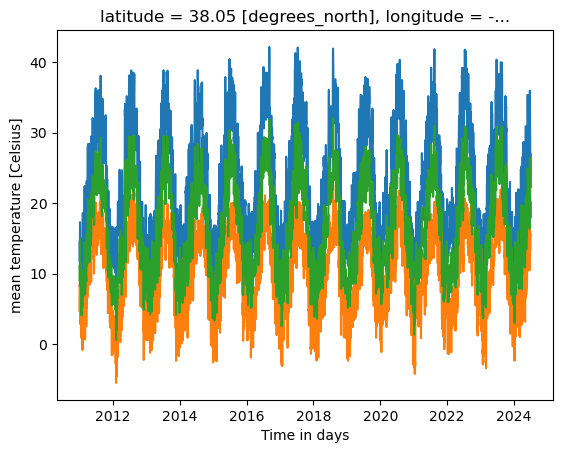

In [7]:
date = "2022-01-01"
long = -7 
lat = 38 
xr_data['tx'].sel(longitude = long , latitude = lat, method = 'nearest').plot()
xr_data['tn'].sel(longitude = long , latitude = lat, method = 'nearest').plot()
xr_data['tg'].sel(longitude = long , latitude = lat, method = 'nearest').plot()

In [8]:
pt = xr_data.sel(latitude = slice(36.5, 42.5), longitude = slice(-10, -6))
grid = {'longitude': pd.array(pt['longitude']), 'latitude': pd.array(pt['latitude'])}

In [ ]:
#Define the point grid that covers Mainland Portugal
df_grid = pd.DataFrame(columns = ['longitude', 'latitude']) 
for i in grid['longitude']:
    for j in grid['latitude']:
       aux = {'longitude': i, 'latitude': j}
       df_grid.loc[len(df_grid)] = aux
# Turn grid into point array
df_geometry = gpd.points_from_xy(df_grid['longitude'], df_grid['latitude'])
multipoint_grid = MultiPoint([Point(x,y) for x,y in df_grid.values])

(-10.145139568427332,
 -5.8551395855895665,
 36.25486057439561,
 42.74486055383231)

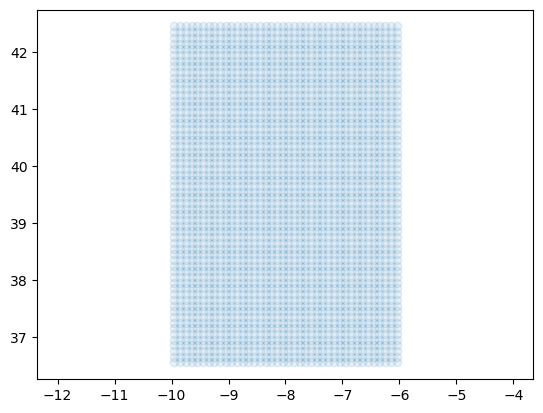

In [11]:
plt.plot(df_grid['longitude'], df_grid['latitude'], 'o', alpha = 0.1)
plt.axis('equal')

## Mainland Portugal Shapefiles

In [12]:
# Read file from Shapefile
sp = "concelhos-shapefile/concelhos.shp"
map = gpd.read_file(sp)

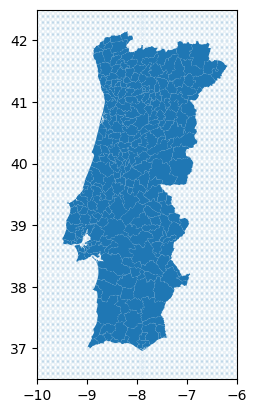

In [13]:
fig = map.plot()
fig.set_xlim([-10,-6])
fig.set_ylim([36.5,42.5])
fig.plot(df_grid['longitude'], df_grid['latitude'], 'x', alpha = 0.1)

In [14]:
# Mainland Portugal
map = map[~map['NAME_1'].isin(['Azores','Madeira'])]
aux_map = pd.DataFrame(map['CCA_2'])

In [18]:
df_long = pd.DataFrame(columns = ['CCA_2','date','t_min', 't_mean', 't_max'])
for idx, row in map.iterrows():
    # Current polygon being considered
    current_polygon = map.loc[idx]['geometry'] 
    # set of points from grid that are contained by the current polygon
    set_in = current_polygon.contains(df_geometry)
    if(not any(set_in)):
        #if no points from grid are contained in the current polygon, select 
        closest_points = nearest_points(current_polygon.centroid, multipoint_grid)
        set_in = MultiPoint(closest_points).contains(df_geometry)
    df_muni = pd.DataFrame(columns = ['CCA_2','date', 't_min', 't_mean', 't_max'])
    CCA_2 = aux_map.loc[idx]['CCA_2']
    for date in xr_data['time'].values:
        day = xr_data.sel(time = date)
        x = xr.DataArray(df_grid[set_in]['longitude'], dims = ['location'])
        y = xr.DataArray(df_grid[set_in]['latitude'], dims = ['location'])
        day = day.sel(longitude = x, latitude = y, method = 'nearest')
        t_mean = np.round(np.mean(day['tg'].values),5)
        t_max = np.round(np.mean(day['tx'].values),5)
        t_min = np.round(np.mean(day['tn'].values),5)
        new_row = {'CCA_2': CCA_2, 'date': date, 't_min': t_min, 't_mean': t_mean, 't_max': t_max, }
        df_muni.loc[len(df_muni)] = new_row
    df_long = pd.concat([df_long, df_muni])


/var/folders/wl/0t2r9ddx3k972b5lztl0bqxm0000gn/T/ipykernel_93294/2705871796.py:23: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_long = pd.concat([df_long, df_muni])


In [30]:
df_long.dtypes

CCA_2             object
date      datetime64[ns]
t_min            float32
t_mean           float32
t_max            float32
dtype: object

In [33]:
# export
df_long = df_long.set_index('date')
df_long.to_csv('temparature_per_muni.xlsx')

## Plot examples

1. Full time series temperature data for one municipality.

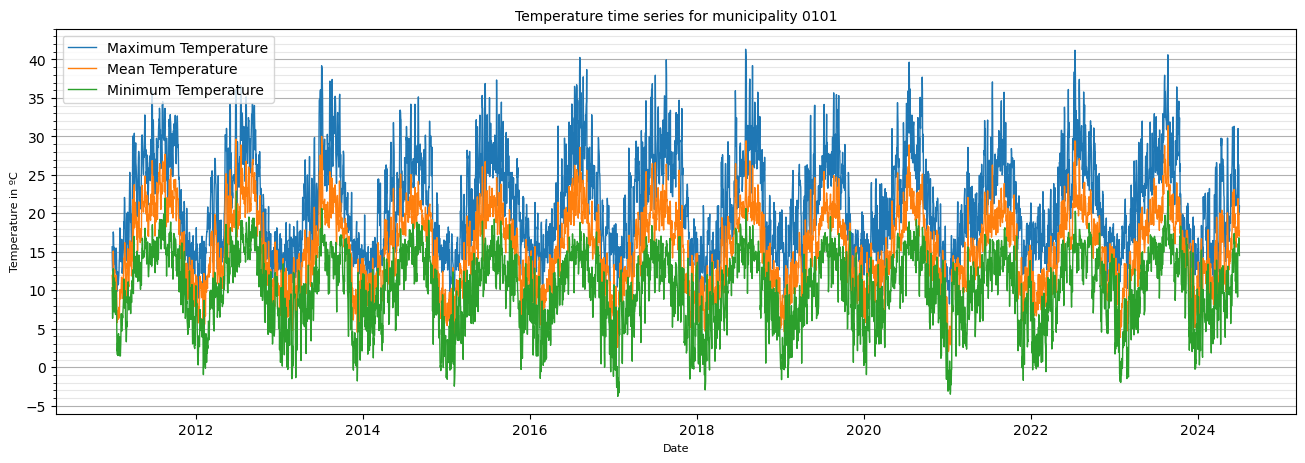

In [68]:
data = df_long[df_long['CCA_2'] == '0101']

plt.subplots(figsize=(16, 5))
plt.plot(data.index, data['t_max'] , label = 'Maximum Temperature', linewidth = 1)
plt.plot(data.index, data['t_mean'], label = 'Mean Temperature', linewidth = 1)
plt.plot(data.index, data['t_min'] , label = 'Minimum Temperature', linewidth = 1)
plt.legend()
plt.title('Temperature time series for municipality 0101', fontsize=10)
plt.xlabel('Date', fontsize=8)
plt.ylabel('Temperature in ºC', fontsize=8)
plt.yticks(np.arange(-5, 45, 5))  
plt.yticks(np.arange(-5, 45, 1), minor=True)  
plt.grid(axis='y')
plt.grid(which='minor', alpha=0.3)     
plt.show()

2. Mean temperature over one day across all municipalities of mainland Portugal

In [76]:
day = dt.datetime(2018,8,15)
left = df_long.loc[day][['CCA_2','t_mean']]
map_day = pd.merge(map, left, how = "left", on = 'CCA_2')

In [97]:
map_day['t_mean']

0      23.816151
1      24.950001
2      24.360001
3      24.434999
4      24.392000
         ...    
273    23.879999
274    22.433340
275    23.330000
276    24.021660
277    21.725000
Name: t_mean, Length: 278, dtype: float32

<Axes: >

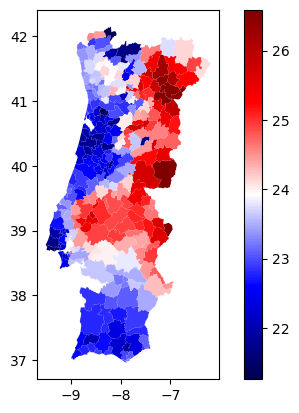

In [ ]:
map_day.plot(column='t_mean', cmap = 'seismic', legend = True, ) 